In [1]:
from typing import Callable, Sequence, Any
from functools import partial
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from aa_train_utils.model_utils import create_model, save_model_params, load_model_params
from aa_train_utils.dataset_generation import joint, uniform, f6, f5, f2, RegressionDataset , generate_noisy_split_trainingdata
from aa_train_utils.spl_curriculum import SPL_curriculum 

import jax
import jax.numpy as jnp
import jax.tree_util
from jax.scipy.stats.norm import logpdf
import pickle
from torch.utils.data import Dataset
from torch.utils.data import Subset
import torch

import numpy as np
import pickle
import flax
import flax.linen as nn

import optax
import jaxopt
import netket as nk

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
#from dataloader import MixtureDataset

from jax.tree_util import tree_map
from torch.utils import data



2024-06-03 12:46:27.091678: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Empirical cross entropy accuracy metrics, using the log likelihood of gaussians and a given target point y.


def cross_entropy_error(model, params, x_context, y_context, x_target, y_target , rng , k):
    y_means, y_stds = model.apply(params, x_context, y_context, x_target,k=k, rngs={'default': rng})


    # Lets compute the log likelihood of the target points given the means and stds

    # Ensure y_means and y_stds are squeezed correctly
    y_means = jnp.squeeze(y_means, axis=-1) if k > 1 else jnp.squeeze(y_means)
    y_stds = jnp.squeeze(y_stds, axis=-1) if k > 1 else jnp.squeeze(y_stds)
    full_y = jnp.squeeze(y_target, axis=-1) if k > 1 else jnp.squeeze(y_target) 

    log_pdf = logpdf(full_y, y_means,y_stds) 
   


    return -jnp.mean(log_pdf)



def RMSE_means(model, params, x_context, y_context, x_target, y_target, rng, k):
    
    y_means, y_stds = model.apply(params, x_context, y_context, x_target,k=k, rngs={'default': rng}) 
    
    
    return jnp.sqrt(jnp.mean((y_means - y_target)**2))


def STD_residuals(model, params, x_context, y_context, x_target, y_target, rng, k):
    
    y_means, y_stds = model.apply(params, x_context, y_context,x_target,k=k, rngs={'default': rng}) 

    return abs(y_target - y_means) / y_stds 


In [3]:
""" TODO:

    - Add validation set to the training loop and log it (In distribution , out of task distribution validations?)

    - Determine how to make sure that SPL curricula and Baseline trains on the same amount of data, as currently SPL doesnt train for same steps with the same epoch number (Maybe introduce a trainined_step_number to cut the training?)

    - Create the empirical cross entropy difficulty measure and use it for the validation set as well. 

    - SPL curriculum call with best_params or just params for the loss calculation based ordering?

    - Additionally maybe increase the difficulty of the dataset a bit , for smoother learning curve, more interesting results? 
        - Could also look into creating a more diverse dataset , the split dataset generator would allow for that easily. 


"""

# There can be several scenarios with the periodic eval and the training step restriction,

# Firstly , and most importantly, we must not train more than the restriction steps. 

# Secondly, if the eval happens and flows into and over the restriction number, the restriction will only be enforced in the next epoch. 

# Thirdly, if the eval is too small of a period , and it fits multuplicatively into the number of batches per epoch, it will only run once and not every period within that epoch. 


def train_spl_curriculum(dataset_key_int,dataloader_key_int, dataset_size, training_step_number, eval_dataset_size, eval_intervals, sampler_ratios, chunk_size, save_path ,  model_name, start_rate, growth_epochs):
    
    """ Training function for the SPL curriculum based Neural Process model training"""



    # Lets define the training functions here and not in their own files, because I couldnt make them modular enough.
    # (The posterior loss was relying on the global variable model, I tried creating a partial with the params not included to have the scan carry over a new param based partial to the step function but it wasnt working, this works for now)

    def posterior_loss(
        params: flax.typing.VariableDict,
        batch,
        key: flax.typing.PRNGKey,
    ):
        key_data, key_model = jax.random.split(key)
        


        X = batch[0]
        y = batch[1]
        x_test = batch[2]
        y_test = batch[3]
        # Compute ELBO over batch of datasets
        elbos = jax.vmap(
        partial(
                model.apply,
                params,  
                beta=kl_penalty,
                k=num_posterior_mc,
                method=model.elbo
        ) 
        )(
            X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, X.shape[0])}
        )
        
        return -elbos.mean()

    @jax.jit
    def step(
        theta: flax.typing.VariableDict, 
        opt_state: optax.OptState,
        current_batch,
        random_key: flax.typing.PRNGKey,
    ) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
        # Implements a generic SGD Step
        
        # value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
        value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, current_batch, random_key )
        
        updates, opt_state = optimizer.update(grad, opt_state, theta)
        theta = optax.apply_updates(theta, updates)
        
        return theta, opt_state, value


    def body_batch(carry, batch):
        params, opt_state, key = carry
        key_carry, key_step = jax.random.split(key)
        # Unpack the batch
        X_full, y_full = batch

        # Shuffle the data while preserving (X, y) pairs
        num_samples = X_full.shape[1]
        indices = jax.random.permutation(key_step, num_samples)
        X_full_shuffled = jnp.take(X_full, indices, axis=1)
        y_full_shuffled = jnp.take(y_full, indices, axis=1)

        # Split the shuffled data into context and test sets
        X, x_test = jnp.split(X_full_shuffled, indices_or_sections=(num_context_samples,), axis=1)
        y, y_test = jnp.split(y_full_shuffled, indices_or_sections=(num_context_samples,), axis=1)

        params, opt_state, value = step(params, opt_state, (X,y, x_test,y_test ), key_step )

        return (params, opt_state, key_carry ), value

    jax.jit
    def scan_train(params, opt_state, key,  batches):
        
        last, out = jax.lax.scan(body_batch, (params, opt_state, key ), batches)

        params, opt_state, _ = last
        
        return params, opt_state, out

    torch.manual_seed(dataloader_key_int) # Setting the seed for the dataloader
    os.makedirs(save_path, exist_ok=True)
    num_context_samples = 64
    num_target_samples = 32
    batch_size = 128
    kl_penalty = 1e-4
    num_posterior_mc = 1


    # First lets create the dataset, 
    # Lets hardcode it for now, and then we can make it more flexible later on
    
    sampler_noise = partial(
        joint, 
        WhiteNoise(f2, 0.2), 
        partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
    )

    sampler_clean = partial(
        joint, 
        f2, 
        partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
    )

    out_task_sampler = partial(
        joint, 
        f5, 
        partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
    )

    out_task_sampler_noise = partial(
        joint,
        WhiteNoise(f5, 0.2),
        partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
    )
    samplers = [sampler_noise, sampler_clean]

    dataset_key = jax.random.PRNGKey(dataset_key_int)
    dataset = RegressionDataset(generate_noisy_split_trainingdata(samplers, sampler_ratios, dataset_size, chunk_size , dataset_key))

    # Lets setup the SPL curriculum

    rng , curricula_key = jax.random.split(dataset_key)
    spl_curricula = SPL_curriculum(start_rate, growth_epochs , dataset, batch_size, curricula_key)



    # Lets initalize the model we are going to train

    rng, key = jax.random.split(rng)

    model , params = create_model(key)
    optimizer = optax.chain(
        optax.clip(.1),
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
    )
    opt_state = optimizer.init(params)

    best, best_params = jnp.inf, params
    losses = list()
    in_task_errors = {'ece':[], 'rmse':[], 'std_residuals':[], "ece_noise": [], "rmse_noise" :[]} # We will log the in task errors for the model
    out_task_errors = {'ece':[], 'rmse':[], 'std_residuals':[], "ece_noise" : [], "rmse_noise": []} # We will log the out of task errors for the model
    training_steps = 0

    for i in (pbar := tqdm.trange(10 ,desc='Optimizing params. ')):
        
        rng, key = jax.random.split(rng)
        _ , eval_epoch_key = jax.random.split(rng)
        model_partial_loss_function = partial(model.apply, params, beta=kl_penalty, k=num_posterior_mc, method=model.elbo) 
        


        batches = jnp.asarray( jax.tree_util.tree_map(lambda tensor : tensor.numpy(), [batch for batch in spl_curricula.data_curriculum(model_partial_loss_function, i, num_context_samples)]))
        # params_new, opt_state, loss = step(params, opt_state, key)
        
        # Right now the number of batches might lead us to over train for the training_step_number, or overtrain for the eval_intervals

        # First take care of the case where we might be overtraining for the eval_intervals. 

        batches_until_eval = eval_intervals - (training_steps % eval_intervals)
        batches_until_end = training_step_number - training_steps
        if batches_until_end < len(batches):
            batches = batches[:batches_until_end]

        # If the batches until eval is less than the batches until end, we eval, then train until batches_until_end - batches_until_eval
        # If the batches until eval is more than the batches until end, we train batches_until_end
        # if the batches until eval is == to batches_until_end, we eval and then let the training end.
        # If the batches until eval is less than the batches until end , but the batches_until_end - (len(batches) - batches_until_eval) is less than 0, we train the rest of the batches and end the training.
        # if the batches_until_end is negative or 0 we break the training loop.  
        print("batches_until_eval", batches_until_eval, "batches_until_end", batches_until_end, "len(batches)", len(batches), "training_steps", training_steps )

        # Okay so if the eval period can fit inside multiple times into a len(batches) it should be run that many times. 
        # It can be done so if 
        # if the len(batches) / eval_intervals is larger than 2 . 


        if batches_until_eval < len(batches):
            # then get the slice to make up the eval_intervals
            
            trained_steps_within_eval = 0
             
            batch_slice_pre_eval = eval_intervals - ( training_steps % eval_intervals )
            batch_slice = batch_slice_pre_eval 
            loss_array_eval = []
            params_new = params
            for i in range(0,1+((len(batches)-batch_slice_pre_eval) // eval_intervals)):
                

                print("current eval loop number", i , "currently trained steps within eval", trained_steps_within_eval , "current batch slice", (trained_steps_within_eval, (trained_steps_within_eval+batch_slice)) ) 
                params_new, opt_state, loss_arr = scan_train(params_new, opt_state, key,batches[trained_steps_within_eval:(trained_steps_within_eval+batch_slice)])

                loss_array_eval.extend(loss_arr)  # dont lose the loss values upon next batch training
                trained_steps_within_eval += batch_slice
                batch_slice = eval_intervals

                eval_epoch_key, eval_inkey_data, eval_outkey_data, eval_model_key = jax.random.split(eval_epoch_key, 4)
                intask_x_eval, intask_y_eval = jax.vmap(sampler_clean)(jax.random.split(eval_inkey_data, eval_dataset_size)) 
                intask_x_eval, intask_y_eval = intask_x_eval[..., None], intask_y_eval[..., None]

                #lets split them into the context and target sets
                x_contexts, x_targets = jnp.split(intask_x_eval, indices_or_sections=(num_context_samples, ), axis=1)
                y_contexts, y_targets = jnp.split(intask_y_eval, indices_or_sections=(num_context_samples, ), axis=1)

                ece_errors = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
                rmse_errors= nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
                std_residuals= nk.jax.vmap_chunked(partial(STD_residuals, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0) , chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
                
                intasknoise_x_eval, intasknoise_y_eval = jax.vmap(sampler_noise)(jax.random.split(eval_inkey_data, eval_dataset_size))
                intasknoise_x_eval, intasknoise_y_eval = intasknoise_x_eval[..., None], intasknoise_y_eval[..., None]

                #lets split them into the context and target sets
                x_contextsnoise, x_targetsnoise = jnp.split(intasknoise_x_eval, indices_or_sections=(num_context_samples, ), axis=1)
                y_contextsnoise, y_targetsnoise = jnp.split(intasknoise_y_eval, indices_or_sections=(num_context_samples, ), axis=1)

                ece_errors_noise = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contextsnoise, y_contextsnoise, x_targetsnoise, y_targetsnoise, jax.random.split(eval_model_key, eval_dataset_size))
                rmse_errors_noise = nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contextsnoise, y_contextsnoise, x_targetsnoise, y_targetsnoise, jax.random.split(eval_model_key, eval_dataset_size))

                in_task_errors['ece_noise'].append((ece_errors_noise.mean(), ece_errors_noise.std()))
                in_task_errors['rmse_noise'].append((rmse_errors_noise.mean(), rmse_errors_noise.std()))
                in_task_errors['ece'].append((ece_errors.mean(), ece_errors.std()))
                in_task_errors['rmse'].append((rmse_errors.mean(), rmse_errors.std()))
                in_task_errors['std_residuals'].append((std_residuals.mean(), std_residuals.std()))

                # Now lets do the out of task evaluation (f for now like the original notebook)
                outtask_x_eval, outtask_y_eval = jax.vmap(out_task_sampler)(jax.random.split(eval_outkey_data, eval_dataset_size))
                outtask_x_eval, outtask_y_eval = outtask_x_eval[..., None], outtask_y_eval[..., None]

                #lets split them into the context and target sets
                x_contexts, x_targets = jnp.split(outtask_x_eval, indices_or_sections=(num_context_samples, ), axis=1)
                y_contexts, y_targets = jnp.split(outtask_y_eval, indices_or_sections=(num_context_samples, ), axis=1)

                ece_errors = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
                rmse_errors= nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
                std_residuals= nk.jax.vmap_chunked(partial(STD_residuals, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size= chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))

                outtasknoise_x_eval, outtasknoise_y_eval = jax.vmap(out_task_sampler_noise)(jax.random.split(eval_inkey_data, eval_dataset_size))
                outtasknoise_x_eval, outtasknoise_y_eval = outtasknoise_x_eval[..., None], outtasknoise_y_eval[..., None]

                #lets split them into the context and target sets
                x_contextsnoise, x_targetsnoise = jnp.split(outtasknoise_x_eval, indices_or_sections=(num_context_samples, ), axis=1)
                y_contextsnoise, y_targetsnoise = jnp.split(outtasknoise_y_eval, indices_or_sections=(num_context_samples, ), axis=1)

                ece_errors_noise = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contextsnoise, y_contextsnoise, x_targetsnoise, y_targetsnoise, jax.random.split(eval_model_key, eval_dataset_size))
                rmse_errors_noise = nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contextsnoise, y_contextsnoise, x_targetsnoise, y_targetsnoise, jax.random.split(eval_model_key, eval_dataset_size))

                print("ece_errors_noise shapes", ece_errors_noise.shape)
                out_task_errors['ece_noise'].append((ece_errors_noise.mean(), ece_errors_noise.std()))
                out_task_errors['rmse_noise'].append((rmse_errors_noise.mean(), rmse_errors_noise.std()))
                out_task_errors['ece'].append((ece_errors.mean(), ece_errors.std()))
                out_task_errors['rmse'].append((rmse_errors.mean(), rmse_errors.std()))
                out_task_errors['std_residuals'].append((std_residuals.mean(), std_residuals.std()))


                

            # Now we can train the rest of the batches
            
            # with trained_steps_within_eval start slicing, only train if len(batches) - trained_steps_within_eval > 0
            if len(batches) - trained_steps_within_eval > 0: 
                print("training on the rest of the remaining batches after eval", len(batches)-trained_steps_within_eval)
                params_new , opt_state, loss_arr = scan_train(params_new, opt_state, key,batches[trained_steps_within_eval:])
                loss_array_eval.extend(loss_arr)
            else:
                print("Eval period was the last period, no more training, eval intervals fit perfectly within this batch.")

            
            loss_arr = jnp.asarray(loss_array_eval)
        else: 
            params_new, opt_state, loss_arr = scan_train(params, opt_state, key,batches)
        
        # Update the training steps
        # Since this variable is only used inside the function and never later , it doesnt matter for the training_step_number restriction if it overcounts.  
        # Although it would so pay attention if implementation changes.
        print(training_steps, len(batches))
        training_steps+= len(batches)

    

        

        losses.extend(loss_arr)

        if loss_arr.min() < best:
            best = loss_arr.min()
            best_params = params_new
        
        if jnp.isnan(loss_arr).any():
            break
        else:
            params = params_new
        
        pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

        if(training_steps >= training_step_number):
            break
    # Lets save what we need to save for the model and training. 

    ### After training we should save  
        # the model parameters with a name that we know how it was trained
        # the losses and other relevant information accrued during training
        # the curriculum weight log for the dataset

    # Saving the model params
    # We could also save opt_state here for later training
    # Also after trying out whether the training would continue saving and loading the params back in I saw change in printed loss. Not sure why that is the case,
    # Even if I restore the opt_state as well. Regardless, the model continued training so saving the params is enough to use the model for evaluation later on. 
    
    print("printing losses length", len(losses))
    save_model_params(best_params,save_path, model_name) 
    
    with open(os.path.join(save_path, model_name + '_curricula_logs.pkl'), 'wb') as f:
        if(len(spl_curricula.weight_log)>0):
            pickle.dump({"curricula_weights": spl_curricula.weight_log , "curricula_losses": spl_curricula.epoch_losses_log}, f)
    
    with open(os.path.join(save_path, model_name + '_training_metrics.pkl'), 'wb') as f:
        pickle.dump({"training_loss" : losses, "training_intask_errors": in_task_errors, "training_outtask_errors": out_task_errors }, f)






# Lets also define a function for the baseline training, so that we can compare the two models later on.

def train_np_baseline(dataset_key_int,dataloader_key_int, dataset_size, training_step_number, eval_dataset_size, eval_intervals,   sampler_ratios, chunk_size, save_path ,  model_name):

    """ Training function for the SPL curriculum based Neural Process model training"""



    # Lets define the training functions here and not in their own files, because I couldnt make them modular enough.
    # (The posterior loss was relying on the global variable model, I tried creating a partial with the params not included to have the scan carry over a new param based partial to the step function but it wasnt working, this works for now)

    def posterior_loss(
        params: flax.typing.VariableDict,
        batch,
        key: flax.typing.PRNGKey,
    ):
        key_data, key_model = jax.random.split(key)



        X = batch[0]
        y = batch[1]
        x_test = batch[2]
        y_test = batch[3]
        # Compute ELBO over batch of datasets
        elbos = jax.vmap(
        partial(
                model.apply,
                params,
                beta=kl_penalty,
                k=num_posterior_mc,
                method=model.elbo
        )
        )(
            X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, X.shape[0])}
        )

        return -elbos.mean()

    @jax.jit
    def step(
        theta: flax.typing.VariableDict,
        opt_state: optax.OptState,
        current_batch,
        random_key: flax.typing.PRNGKey,
    ) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
        # Implements a generic SGD Step

        # value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
        value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, current_batch, random_key )

        updates, opt_state = optimizer.update(grad, opt_state, theta)
        theta = optax.apply_updates(theta, updates)

        return theta, opt_state, value


   
    def body_batch(carry, batch):
        params, opt_state, key = carry
        key_carry, key_step = jax.random.split(key)
        # Unpack the batch
        X_full, y_full = batch

        # Shuffle the data while preserving (X, y) pairs
        num_samples = X_full.shape[1]
        indices = jax.random.permutation(key_step, num_samples)
        X_full_shuffled = jnp.take(X_full, indices, axis=1)
        y_full_shuffled = jnp.take(y_full, indices, axis=1)

        # Split the shuffled data into context and test sets
        X, x_test = jnp.split(X_full_shuffled, indices_or_sections=(num_context_samples,), axis=1)
        y, y_test = jnp.split(y_full_shuffled, indices_or_sections=(num_context_samples,), axis=1)

        params, opt_state, value = step(params, opt_state, (X,y, x_test,y_test ), key_step )

        return (params, opt_state, key_carry ), value


    jax.jit
    def scan_train(params, opt_state, key,  batches):

        last, out = jax.lax.scan(body_batch, (params, opt_state, key ), batches)

        params, opt_state, _ = last

        return params, opt_state, out


    torch.manual_seed(dataloader_key_int) # Setting the seed for the dataloader
    os.makedirs(save_path, exist_ok=True)
    num_context_samples = 64
    num_target_samples = 32
    batch_size = 128
    kl_penalty = 1e-4
    num_posterior_mc = 1


    # First lets create the dataset,
    # Lets hardcode it for now, and then we can make it more flexible later on

    sampler_noise = partial(
        joint,
        WhiteNoise(f2, 0.1),
        partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
    )

    sampler_clean = partial(
        joint,
        f2,
        partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
    )
    out_task_sampler = partial(
        joint, 
        f5, 
        partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
    )
    out_task_sampler_noise = partial(
        joint,
        WhiteNoise(f5, 0.2),
        partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
    )
    samplers = [sampler_noise, sampler_clean]

    dataset_key = jax.random.PRNGKey(dataset_key_int)
    dataset = RegressionDataset(generate_noisy_split_trainingdata(samplers, sampler_ratios, dataset_size, chunk_size , dataset_key))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    # Lets setup the SPL curriculum

    rng , curricula_key = jax.random.split(dataset_key)


    # Lets initalize the model we are going to train

    rng, key = jax.random.split(rng)

    model , params = create_model(key)
    optimizer = optax.chain(
        optax.clip(.1),
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
    )
    opt_state = optimizer.init(params)

    best, best_params = jnp.inf, params
    losses = list()
    in_task_errors = {'ece':[], 'rmse':[], 'std_residuals':[], "ece_noise" : [], "rmse_noise": []} # We will log the in task errors for the model
    out_task_errors = {'ece':[], 'rmse':[], 'std_residuals':[], "ece_noise": [], "rmse_noise": []} # We will log the out of task errors for the model
    training_steps = 0

    for i in (pbar := tqdm.trange(10 ,desc='Optimizing params. ')):

        rng, key = jax.random.split(rng)
        _ , eval_epoch_key = jax.random.split(rng)
        

        batches = jnp.asarray( jax.tree_util.tree_map(lambda tensor : tensor.numpy(), [batch for batch in dataloader]))
        # params_new, opt_state, loss = step(params, opt_state, key)

        batches_until_eval = eval_intervals - (training_steps % eval_intervals)
        batches_until_end = training_step_number - training_steps
        if batches_until_end < len(batches):
            batches = batches[:batches_until_end]

        # If the batches until eval is less than the batches until end, we eval, then train until batches_until_end - batches_until_eval
        # If the batches until eval is more than the batches until end, we train batches_until_end
        # if the batches until eval is == to batches_until_end, we eval and then let the training end.
        # If the batches until eval is less than the batches until end , but the batches_until_end - (len(batches) - batches_until_eval) is less than 0, we train the rest of the batches and end the training.
        # if the batches_until_end is negative or 0 we break the training loop.  
        print("batches_until_eval", batches_until_eval, "batches_until_end", batches_until_end, "len(batches)", len(batches), "training_steps", training_steps )

        # Okay so if the eval period can fit inside multiple times into a len(batches) it should be run that many times. 
        # It can be done so if 
        # if the len(batches) / eval_intervals is larger than 2 . 


        if batches_until_eval < len(batches):
            # then get the slice to make up the eval_intervals
            
            trained_steps_within_eval = 0
             
            batch_slice_pre_eval = eval_intervals - ( training_steps % eval_intervals )
            batch_slice = batch_slice_pre_eval 
            loss_array_eval = []
            params_new = params
            for i in range(0,1+((len(batches)-batch_slice_pre_eval) // eval_intervals)):
                

                print("current eval loop number", i , "currently trained steps within eval", trained_steps_within_eval , "current batch slice", (trained_steps_within_eval, (trained_steps_within_eval+batch_slice)) ) 
                params_new, opt_state, loss_arr = scan_train(params_new, opt_state, key,batches[trained_steps_within_eval:(trained_steps_within_eval+batch_slice)])

                loss_array_eval.extend(loss_arr)  # dont lose the loss values upon next batch training
                trained_steps_within_eval += batch_slice
                batch_slice = eval_intervals

                eval_epoch_key, eval_inkey_data, eval_outkey_data, eval_model_key = jax.random.split(eval_epoch_key, 4)
                intask_x_eval, intask_y_eval = jax.vmap(sampler_clean)(jax.random.split(eval_inkey_data, eval_dataset_size)) 
                intask_x_eval, intask_y_eval = intask_x_eval[..., None], intask_y_eval[..., None]

                #lets split them into the context and target sets
                x_contexts, x_targets = jnp.split(intask_x_eval, indices_or_sections=(num_context_samples, ), axis=1)
                y_contexts, y_targets = jnp.split(intask_y_eval, indices_or_sections=(num_context_samples, ), axis=1)

                ece_errors = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
                rmse_errors= nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
                std_residuals= nk.jax.vmap_chunked(partial(STD_residuals, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0) , chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
                
                intasknoise_x_eval, intasknoise_y_eval = jax.vmap(sampler_noise)(jax.random.split(eval_inkey_data, eval_dataset_size))
                intasknoise_x_eval, intasknoise_y_eval = intasknoise_x_eval[..., None], intasknoise_y_eval[..., None]

                #lets split them into the context and target sets
                x_contextsnoise, x_targetsnoise = jnp.split(intasknoise_x_eval, indices_or_sections=(num_context_samples, ), axis=1)
                y_contextsnoise, y_targetsnoise = jnp.split(intasknoise_y_eval, indices_or_sections=(num_context_samples, ), axis=1)

                ece_errors_noise = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contextsnoise, y_contextsnoise, x_targetsnoise, y_targetsnoise, jax.random.split(eval_model_key, eval_dataset_size))
                rmse_errors_noise = nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contextsnoise, y_contextsnoise, x_targetsnoise, y_targetsnoise, jax.random.split(eval_model_key, eval_dataset_size))

                in_task_errors['ece_noise'].append((ece_errors_noise.mean(), ece_errors_noise.std()))
                in_task_errors['rmse_noise'].append((rmse_errors_noise.mean(), rmse_errors_noise.std()))
                in_task_errors['ece'].append((ece_errors.mean(), ece_errors.std()))
                in_task_errors['rmse'].append((rmse_errors.mean(), rmse_errors.std()))
                in_task_errors['std_residuals'].append((std_residuals.mean(), std_residuals.std()))

                # Now lets do the out of task evaluation (f for now like the original notebook)
                outtask_x_eval, outtask_y_eval = jax.vmap(out_task_sampler)(jax.random.split(eval_outkey_data, eval_dataset_size))
                outtask_x_eval, outtask_y_eval = outtask_x_eval[..., None], outtask_y_eval[..., None]

                #lets split them into the context and target sets
                x_contexts, x_targets = jnp.split(outtask_x_eval, indices_or_sections=(num_context_samples, ), axis=1)
                y_contexts, y_targets = jnp.split(outtask_y_eval, indices_or_sections=(num_context_samples, ), axis=1)

                ece_errors = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
                rmse_errors= nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
                std_residuals= nk.jax.vmap_chunked(partial(STD_residuals, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size= chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))

                outtasknoise_x_eval, outtasknoise_y_eval = jax.vmap(out_task_sampler_noise)(jax.random.split(eval_inkey_data, eval_dataset_size))
                outtasknoise_x_eval, outtasknoise_y_eval = outtasknoise_x_eval[..., None], outtasknoise_y_eval[..., None]

                #lets split them into the context and target sets
                x_contextsnoise, x_targetsnoise = jnp.split(outtasknoise_x_eval, indices_or_sections=(num_context_samples, ), axis=1)
                y_contextsnoise, y_targetsnoise = jnp.split(outtasknoise_y_eval, indices_or_sections=(num_context_samples, ), axis=1)

                ece_errors_noise = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contextsnoise, y_contextsnoise, x_targetsnoise, y_targetsnoise, jax.random.split(eval_model_key, eval_dataset_size))
                rmse_errors_noise = nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contextsnoise, y_contextsnoise, x_targetsnoise, y_targetsnoise, jax.random.split(eval_model_key, eval_dataset_size))


                out_task_errors['ece_noise'].append((ece_errors_noise.mean(), ece_errors_noise.std()))
                out_task_errors['rmse_noise'].append((rmse_errors_noise.mean(), rmse_errors_noise.std()))
                out_task_errors['ece'].append((ece_errors.mean(), ece_errors.std()))
                out_task_errors['rmse'].append((rmse_errors.mean(), rmse_errors.std()))
                out_task_errors['std_residuals'].append((std_residuals.mean(), std_residuals.std()))


                

            # Now we can train the rest of the batches
            
            # with trained_steps_within_eval start slicing, only train if len(batches) - trained_steps_within_eval > 0
            if len(batches) - trained_steps_within_eval > 0: 
                print("training on the rest of the remaining batches after eval", len(batches)-trained_steps_within_eval)
                params_new , opt_state, loss_arr = scan_train(params_new, opt_state, key,batches[trained_steps_within_eval:])
                loss_array_eval.extend(loss_arr)
            else:
                print("Eval period was the last period, no more training, eval intervals fit perfectly within this batch.")

            
            loss_arr = jnp.asarray(loss_array_eval)
        else: 
            params_new, opt_state, loss_arr = scan_train(params, opt_state, key,batches)
        
        # Update the training steps
        # Since this variable is only used inside the function and never later , it doesnt matter for the training_step_number restriction if it overcounts.  
        # Although it would so pay attention if implementation changes.
        print(training_steps, len(batches))
        training_steps+= len(batches)
        losses.extend(loss_arr)

        if loss_arr.min() < best:
            best = loss_arr.min()
            best_params = params_new

        if jnp.isnan(loss_arr).any():
            break
        else:
            params = params_new

        pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

        if(training_steps >= training_step_number):
            break
    # Lets save what we need to save for the model and training.

    ### After training we should save
        # the model parameters with a name that we know how it was trained
        # the losses and other relevant information accrued during training
        # the curriculum weight log for the dataset

    # Saving the model params
    # We could also save opt_state here for later training
    # Also after trying out whether the training would continue saving and loading the params back in I saw change in printed loss. Not sure why that is the case,
    # Even if I restore the opt_state as well. Regardless, the model continued training so saving the params is enough to use the model for evaluation later on.

    save_model_params(best_params,save_path, model_name)

    with open(os.path.join(save_path, model_name + '_training_metrics.pkl'), 'wb') as f:
        pickle.dump({"training_loss" : losses, "training_intask_errors": in_task_errors, "training_outtask_errors": out_task_errors }, f)




In [ ]:

train_np_baseline(0,0, 128*100, 300, 128*10, 50, [0.3,0.7], 128, ".experiment_data_0/baseline_training_data/", "baseline_model_0")

In [16]:

train_np_baseline(0,0, 128*100, 300, 128*10, 50, [0.3,0.7], 128, "./baseline_training_data/", "baseline_model_0")
train_spl_curriculum(0,0, 128*100, 300, 128*10, 50, [0.3,0.7], 128, "./spl_training_data/", "spl_model_0", 0.1, 5)


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

batches_until_eval 50 batches_until_end 300 len(batches) 100 training_steps 0
current eval loop number 0 currently trained steps within eval 0 current batch slice (0, 50)
current eval loop number 1 currently trained steps within eval 50 current batch slice (50, 100)
Eval period was the last period, no more training, eval intervals fit perfectly within this batch.


Optimizing params. Loss: 1.3017:  10%|█         | 1/10 [00:35<05:16, 35.15s/it]

0 100
batches_until_eval 50 batches_until_end 200 len(batches) 100 training_steps 100
current eval loop number 0 currently trained steps within eval 0 current batch slice (0, 50)
current eval loop number 1 currently trained steps within eval 50 current batch slice (50, 100)
Eval period was the last period, no more training, eval intervals fit perfectly within this batch.


Optimizing params. Loss: 1.0968:  20%|██        | 2/10 [01:07<04:25, 33.24s/it]

100 100
batches_until_eval 50 batches_until_end 100 len(batches) 100 training_steps 200
current eval loop number 0 currently trained steps within eval 0 current batch slice (0, 50)
current eval loop number 1 currently trained steps within eval 50 current batch slice (50, 100)
Eval period was the last period, no more training, eval intervals fit perfectly within this batch.


Optimizing params. Loss: 1.0960:  20%|██        | 2/10 [01:40<06:43, 50.41s/it]

200 100



Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 1280 curr_data_rate 0.1 epoch number 0
sorted indices shape (1280,)
batches_until_eval 50 batches_until_end 300 len(batches) 10 training_steps 0
0 10


Optimizing params. Loss: 1.4952:  10%|█         | 1/10 [00:09<01:28,  9.84s/it]

curr_data_size 3584 curr_data_rate 0.28 epoch number 1
sorted indices shape (3584,)
batches_until_eval 40 batches_until_end 290 len(batches) 28 training_steps 10
10 28


Optimizing params. Loss: 1.6069:  20%|██        | 2/10 [00:21<01:25, 10.71s/it]

curr_data_size 5888 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (5888,)
batches_until_eval 12 batches_until_end 262 len(batches) 46 training_steps 38
current eval loop number 0 currently trained steps within eval 0 current batch slice (0, 12)
ece_errors_noise shapes (1280,)
training on the rest of the remaining batches after eval 34


Optimizing params. Loss: 1.4782:  30%|███       | 3/10 [00:49<02:11, 18.72s/it]

38 46
curr_data_size 8192 curr_data_rate 0.64 epoch number 3
sorted indices shape (8192,)
batches_until_eval 16 batches_until_end 216 len(batches) 64 training_steps 84
current eval loop number 0 currently trained steps within eval 0 current batch slice (0, 16)
ece_errors_noise shapes (1280,)
training on the rest of the remaining batches after eval 48


Optimizing params. Loss: 1.3235:  40%|████      | 4/10 [01:20<02:20, 23.43s/it]

84 64
curr_data_size 10496 curr_data_rate 0.82 epoch number 4
sorted indices shape (10496,)
batches_until_eval 2 batches_until_end 152 len(batches) 82 training_steps 148
current eval loop number 0 currently trained steps within eval 0 current batch slice (0, 2)
ece_errors_noise shapes (1280,)
current eval loop number 1 currently trained steps within eval 2 current batch slice (2, 52)
ece_errors_noise shapes (1280,)
training on the rest of the remaining batches after eval 30


Optimizing params. Loss: 0.9896:  50%|█████     | 5/10 [02:07<02:39, 31.92s/it]

148 82
curr_data_size 12799 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (12799,)
batches_until_eval 20 batches_until_end 70 len(batches) 70 training_steps 230
current eval loop number 0 currently trained steps within eval 0 current batch slice (0, 20)
ece_errors_noise shapes (1280,)
current eval loop number 1 currently trained steps within eval 20 current batch slice (20, 70)
ece_errors_noise shapes (1280,)
Eval period was the last period, no more training, eval intervals fit perfectly within this batch.


Optimizing params. Loss: 0.7376:  50%|█████     | 5/10 [02:46<02:46, 33.24s/it]

230 70
printing losses length 300


300


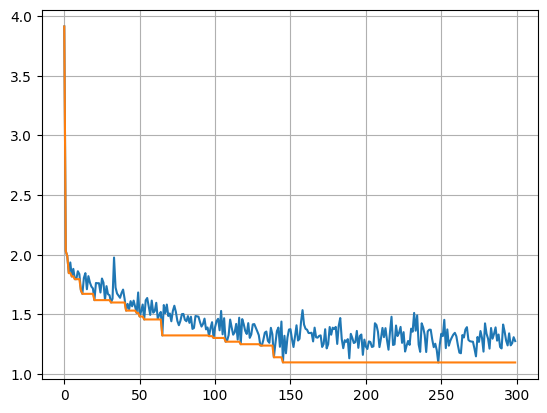

In [11]:

# lets get things for baseline plots
with open("./baseline_training_data/baseline_model_0_training_metrics.pkl", 'rb') as f:
    baseline_training_metrics = pickle.load(f)

print(len(baseline_training_metrics['training_loss']))
plt.plot(baseline_training_metrics['training_loss'])
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(baseline_training_metrics['training_loss'])))
plt.grid()

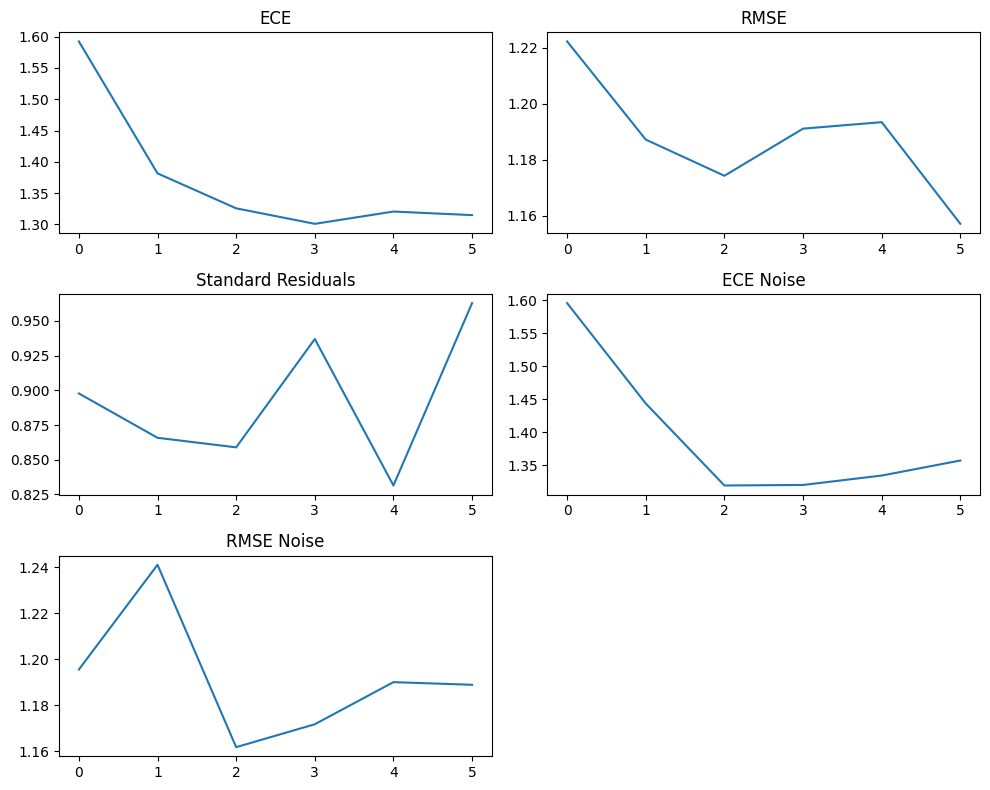

In [12]:

plt.figure(figsize=(10, 8))

plt.subplot(3, 2, 1)
plt.plot(baseline_training_metrics['training_intask_errors']['ece'])
plt.title('ECE')

plt.subplot(3, 2, 2)
plt.plot(baseline_training_metrics['training_intask_errors']['rmse'])
plt.title('RMSE')

plt.subplot(3, 2, 3)
plt.plot(baseline_training_metrics['training_intask_errors']['std_residuals'])
plt.title('Standard Residuals')

plt.subplot(3, 2, 4)
plt.plot(baseline_training_metrics['training_intask_errors']['ece_noise'])
plt.title('ECE Noise')

plt.subplot(3, 2, 5)
plt.plot(baseline_training_metrics['training_intask_errors']['rmse_noise'])
plt.title('RMSE Noise')

plt.tight_layout()
plt.show()

dict_keys(['curricula_weights', 'curricula_losses'])
[(1280,), (3584,), (5888,), (8192,), (10496,), (12799,)]
------
[12800, 12800, 12800, 12800, 12800, 12800]
300
[Array(1.93723144, dtype=float64), Array(1.82779919, dtype=float64), Array(1.67967006, dtype=float64), Array(1.65503768, dtype=float64), Array(1.63334217, dtype=float64), Array(1.54487552, dtype=float64), Array(1.49593818, dtype=float64), Array(1.49693267, dtype=float64), Array(1.49520947, dtype=float64), Array(1.70225248, dtype=float64), Array(1.66753379, dtype=float64), Array(1.67888484, dtype=float64), Array(1.65588533, dtype=float64), Array(1.66794582, dtype=float64), Array(1.66768787, dtype=float64), Array(1.67304122, dtype=float64), Array(1.64003881, dtype=float64), Array(1.65180975, dtype=float64), Array(1.63647752, dtype=float64), Array(1.63803038, dtype=float64), Array(1.64226896, dtype=float64), Array(1.62527101, dtype=float64), Array(1.64989549, dtype=float64), Array(1.62665202, dtype=float64), Array(1.63401377, d

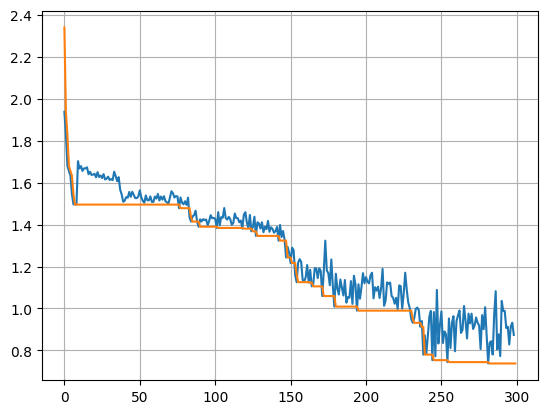

In [14]:
# Lets check if the necessary savings happened nicely

# First the curriculum weights. 

with open("./spl_training_data/spl_model_0_curricula_logs.pkl", 'rb') as f:
    curricula_logs= pickle.load(f)

print(curricula_logs.keys())
print([w.shape for w in curricula_logs["curricula_weights"]])
print("------")

print([len(w) for w in curricula_logs["curricula_losses"]])
# Now the training metrics

with open("./spl_training_data/spl_model_0_training_metrics.pkl", 'rb') as f:
    training_metrics = pickle.load(f)

print(len(training_metrics["training_loss"]))
print(training_metrics["training_loss"][1:])
plt.plot(training_metrics["training_loss"][1:])
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(training_metrics["training_loss"])))
plt.grid()

# Finally the model params

print("training in task errors")
print(training_metrics["training_intask_errors"])
print(len(training_metrics["training_intask_errors"]["rmse"]))

print(" training outtask errors")
print(training_metrics["training_outtask_errors"])
print(len(training_metrics["training_outtask_errors"]['ece']))

print("---------------")

params = load_model_params("./spl_training_data/spl_model_0.pkl")

print(jax.tree_util.tree_map(lambda x: x.shape, params))



[(Array(1.3140872, dtype=float64), Array(0.2508995, dtype=float64)), (Array(1.26334016, dtype=float64), Array(0.30377323, dtype=float64)), (Array(1.08836937, dtype=float64), Array(0.43210335, dtype=float64)), (Array(0.90049036, dtype=float64), Array(0.74328664, dtype=float64)), (Array(0.87486794, dtype=float64), Array(0.76361936, dtype=float64)), (Array(0.85936074, dtype=float64), Array(0.79679637, dtype=float64))]
Means: [Array(1.3140872, dtype=float64), Array(1.26334016, dtype=float64), Array(1.08836937, dtype=float64), Array(0.90049036, dtype=float64), Array(0.87486794, dtype=float64), Array(0.85936074, dtype=float64)]
Standard Deviations: [Array(0.2508995, dtype=float64), Array(0.30377323, dtype=float64), Array(0.43210335, dtype=float64), Array(0.74328664, dtype=float64), Array(0.76361936, dtype=float64), Array(0.79679637, dtype=float64)]


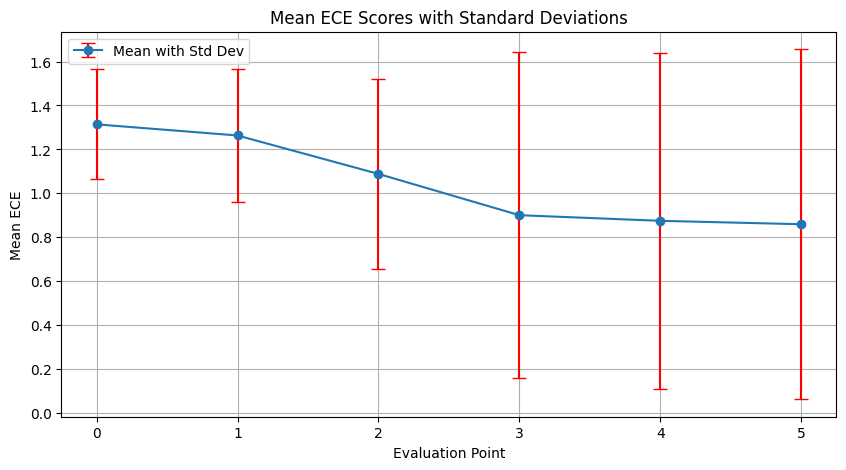

In [15]:
# Empirical cross entropy accuracy metrics, using the log likelihood of gaussians and a given target point y.
print(training_metrics["training_intask_errors"]["ece"])


means = [ t[0] for t in training_metrics["training_intask_errors"]["ece"]]

stds= [ t[1] for t in training_metrics["training_intask_errors"]["ece"]]

# Indices for the x-axis
x = np.arange(len(means))

# Print the data to verify
print("Means:", means)
print("Standard Deviations:", stds)

# Plot the means with error bars representing the standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(x, means, yerr=stds, fmt='-o', ecolor='r', capsize=5, label='Mean with Std Dev')

# Add labels and title
plt.xlabel('Evaluation Point')
plt.ylabel('Mean ECE')
plt.title('Mean ECE Scores with Standard Deviations')
plt.legend()

# Show grid
plt.grid(True)

# Show the plot
plt.show()

In [3]:
loaded_params = load_model_params("./spl_training_data/spl_model_0.pkl")

model_rng , key_model = jax.random.split(jax.random.PRNGKey(232))
model, init_params = create_model(model_rng)

In [7]:
num_context_samples = 64
num_target_samples = 32
batch_size = 128
kl_penalty = 1e-4
num_posterior_mc = 1
acc_rng = jax.random.PRNGKey(42)

acc_rng , dataset_key = jax.random.split(acc_rng)
# Lets sample a in trask distribution dataset

sampler_clean = partial(
    joint, 
    f2, 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)


# lets get 1280 samples from the dataset

x ,y= sampler_clean(dataset_key) 
print(x.shape, y.shape)

x, y = x[..., None], y[..., None]

print(x.shape, y.shape)

x_context, x_target = jnp.split(x, indices_or_sections=(num_context_samples, ))
y_context, y_target = jnp.split(y, indices_or_sections=(num_context_samples, ))

print(x_context.shape, y_context.shape, x_target.shape, y_target.shape)


full_x = jnp.concatenate([x_context, x_target])
print(full_x.shape)

acc = cross_entropy_error(model, loaded_params, x_context, y_context, x_target, y_target, acc_rng, 1)

xs , ys = jax.vmap(sampler_clean)(jax.random.split(dataset_key,128))

print(xs.shape, ys.shape)

xs, ys = xs[..., None], ys[..., None]

x_contexts, x_targets = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)

y_contexts, y_targets = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)

print(x_contexts.shape, y_contexts.shape, x_targets.shape, y_targets.shape)

accs = jax.vmap(partial(cross_entropy_error, model, loaded_params, k=1), in_axes=(0,0,0,0,0))(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(acc_rng, 128))

print(accs.mean())

rmse_accs = jax.vmap(partial(RMSE_means, model, loaded_params, k=1), in_axes=(0,0,0,0,0))(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(acc_rng, 128))

print(rmse_accs.mean())

std_residuals = jax.vmap(partial(STD_residuals, model, loaded_params, k=1), in_axes=(0,0,0,0,0))(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(acc_rng, 128))

print(std_residuals.mean())

(96,) (96,)
(96, 1) (96, 1)
(64, 1) (64, 1) (32, 1) (32, 1)
(96, 1)
(128, 96) (128, 96)
(128, 64, 1) (128, 64, 1) (128, 32, 1) (128, 32, 1)
0.8013514945015208
0.6771679635620735
0.8971309444540768


In [ ]:
# Lets work on the plotting code for several training runs together. 

# We will have a certain folder that will have all the training metrics for a given training run , done 5 times. 

# How exactly do I plan to plot things? For example the training , do I plot per training setup baseline + spl all in different plots, or on the same plot? Probably different plots for now. 


# Also how do I plot the curricula related things? Do I use all the available ones or I only show one training run curricula? How can we average them out? 

# 

/tmp/ipykernel_5296/3949277441.py:8: RuntimeWarning: divide by zero encountered in divide
  data_rate = min(1.0, start_rate + (1.0 - start_rate) / growth_epochs * epoch)


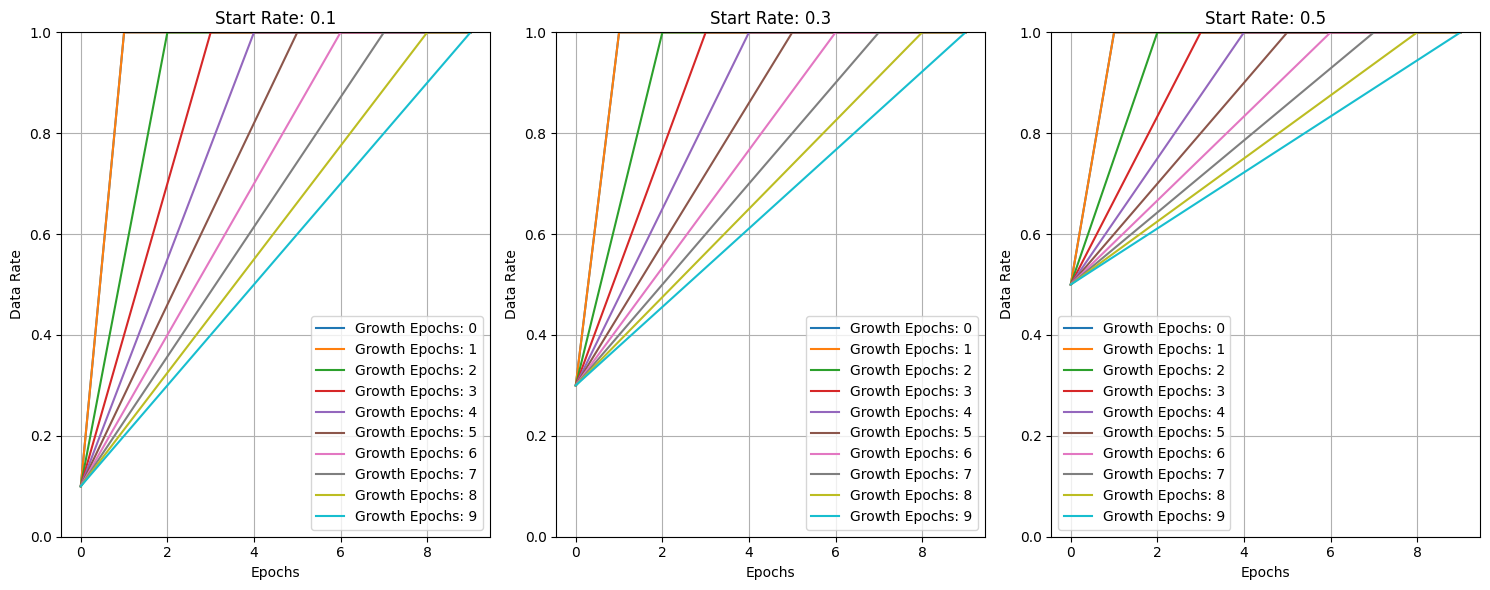

In [20]:
# Define the function to calculate data_rate over epochs
def calculate_data_rate(start_rate, growth_epochs, num_epochs):
    data_rates = []
    for epoch in range(num_epochs):
        if epoch == 0:
            data_rate = start_rate
        else:
            data_rate = min(1.0, start_rate + (1.0 - start_rate) / growth_epochs * epoch)
        data_rates.append(data_rate)
    return data_rates

# Define parameters to visualize
start_rates = [0.1, 0.3, 0.5]  # Different start rates
growth_epochs_list = np.arange(10)# Different growth epochs
num_epochs = 10  # Number of epochs

# Plot data_rate over epochs for different start_rates
plt.figure(figsize=(15, 6))
for i, start_rate in enumerate(start_rates, 1):
    plt.subplot(1, len(start_rates), i)
    plt.title(f'Start Rate: {start_rate}')
    for growth_epochs in growth_epochs_list:
        data_rates = calculate_data_rate(start_rate, growth_epochs, num_epochs)
        plt.plot(range(num_epochs), data_rates, label=f"Growth Epochs: {growth_epochs}")

    # Add labels and legend to the subplot
    plt.xlabel('Epochs')
    plt.ylabel('Data Rate')
    plt.legend()
    plt.grid(True)
    # Set consistent y-axis limits
    plt.ylim(0.0, 1.0)


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

6
6


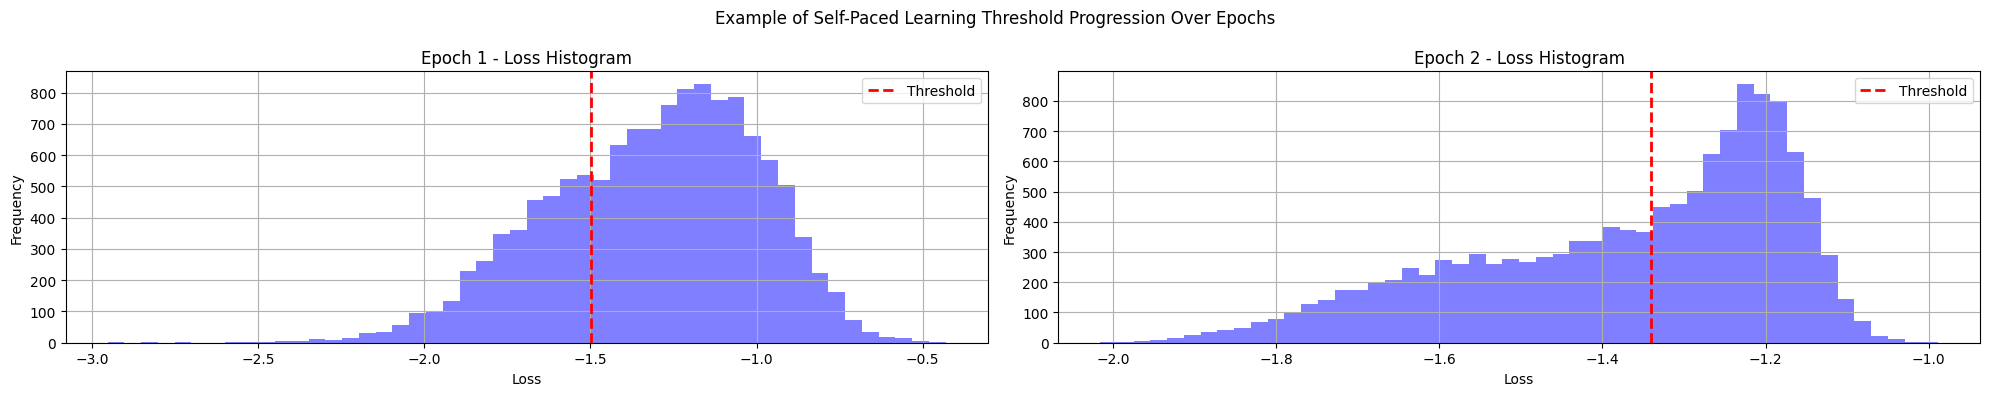

In [40]:
# Curricula weights and loss plotting for visual aid and progression over the epochs. 

# Load the curricula logs
with open("./spl_training_data/spl_model_0_curricula_logs.pkl", 'rb') as f:
    curricula_logs = pickle.load(f)

# Extract the necessary data
curricula_losses = curricula_logs["curricula_losses"]
curricula_indices = curricula_logs["curricula_weights"]

print(len(curricula_losses))
print(len(curricula_indices))
# Define the number of bins for the histogram
num_bins = 50

# Plot histograms for losses in each epoch with bars for curricula cutoffs
num_epochs = 3
plt.figure(figsize=(20, 4))
plt.suptitle('Example of Self-Paced Learning Threshold Progression Over Epochs')
for epoch, (losses, indices) in enumerate(zip(curricula_losses[1:num_epochs], curricula_indices[1:num_epochs]), 1):
    plt.subplot(1, 2, epoch)
    plt.hist(losses, bins=num_bins, color='blue', alpha=0.5)
    plt.axvline(x=losses[indices[-1]], color='r', linestyle='--', linewidth=2, label='Threshold')
    
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.title(f'Epoch {epoch} - Loss Histogram')
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()